## Cargar librerías y datos

In [1]:
%matplotlib inline      
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_validate, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report,precision_score
from sklearn.feature_selection import RFE,RFECV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from patsy import dmatrices
import time
sns.set_style('whitegrid')     ###quizas comentar esta parte

## Preparar datos

In [2]:
ventanadetiempo=250    #se usaran input muestras para fitear el modelo
ventana_historia_hacia_atras=203  #Cuantos dias hacia atras hacer la simulacion  #notar que se entregaran el input+1 fairvalues
dias_a_predecir=30  # cambiar nombre
dt=1    # 
ventana_tiempo_media_movil=30             #separar inputs de la parte de cargar datos  #enfatizar en que momento se hace el ventana_tiempo_media_movil 
df=pd.read_excel("Data_CLP_BBG.xlsx",sheet_name=1)
df = df[df.columns.drop(list(df.filter(regex='Index.1')))]
df.drop_duplicates()
df=df.interpolate()                 #Interpolate missing values
df=df.dropna(axis=0)
df=df.dropna().reset_index(drop=True)
df=df.iloc[::dt, :]     
df.reset_index(drop=True,inplace=True)
df=df.set_index("Dates")
returns = df.pct_change() 
dflog = np.log(1+returns)
dflog=dflog.add_suffix(" log_returns")
dflog=dflog.interpolate()
dflog=dflog.dropna(axis=0)
dfma=df.rolling(ventana_tiempo_media_movil).mean()
dfma=dfma.add_suffix(f" Media_móvil_{ventana_tiempo_media_movil}_días")
df_delta=df.diff(periods=1)

## Variables a analizar

In [3]:
list(df.columns.values)

['CLP Curncy',
 'HG1 Comdty',
 'SPX Index',
 'BBDXY Index',
 'LACI Index',
 'USOSFR1 Curncy',
 'USOSFR5 Curncy',
 'USOSFR10 Curncy',
 'MXN Curncy',
 'BRL Curncy',
 'EUR Curncy',
 'CL1 Comdty',
 'CHSWP1 Curncy',
 'CHSWP5 Curncy',
 'CHSWP10 Curncy',
 'IPSA Index']

In [4]:
variables_a_analizar=['CLP Curncy',
# 'HG1 Comdty',
# 'SPX Index',
# 'BBDXY Index',
# 'LACI Index',
# 'USOSFR1 Curncy',
# 'USOSFR5 Curncy',
# 'USOSFR10 Curncy',
 'MXN Curncy',
 'BRL Curncy',
 'EUR Curncy']
# 'CL1 Comdty',
# 'CHSWP1 Curncy',
# 'CHSWP5 Curncy',
# 'CHSWP10 Curncy',
# 'IPSA Index'
df_an=df.loc[:,variables_a_analizar]
variables_a_analizar_log=[i + " log_returns" for i in variables_a_analizar]
dflog_an=dflog.loc[:,variables_a_analizar_log]
variables_a_analizar_dfma=[i + " Media_móvil_{}_días".format(ventana_tiempo_media_movil) for i in variables_a_analizar]
dfma_an=dfma.loc[:,variables_a_analizar_dfma]

## Outliers

In [6]:
sigmas_para_outliers=3 #cambiar nombre quizas
newdf_log=dflog_an[(dflog_an < dflog_an.mean()+sigmas_para_outliers*dflog_an.std()) & (dflog_an > dflog_an.mean()-sigmas_para_outliers*dflog_an.std())]
newdf_log=newdf_log.interpolate()
mask=(dflog_an > dflog_an.mean()+sigmas_para_outliers*dflog_an.std()) | (dflog_an < dflog_an.mean()-sigmas_para_outliers*dflog_an.std())
mask.columns=list(df_an.columns.values)
newdf_an=df_an.iloc[1:,:].mask(mask)
newdf_an=pd.concat([pd.DataFrame(df_an.iloc[0,:]).transpose(),newdf_an])
newdf_an=newdf_an.interpolate()
newdf_log.iloc[0,:]=dflog_an.iloc[0,:]    #Esto es por si queda un nan en el primer valor , para no perder informacion,luego se interpola
newdf_log.interpolate()

,CLP Curncy log_returns,MXN Curncy log_returns,BRL Curncy log_returns,EUR Curncy log_returns
Dates,,,,
2007-01-03,0.010835,0.003992,0.003887,-0.007866
2007-01-04,0.005540,0.007552,0.002194,-0.006475
2007-01-05,0.001422,0.002849,0.003817,-0.006287
2007-01-08,0.002451,0.001234,-0.000511,0.001691
2007-01-09,-0.001842,0.004649,-0.001023,-0.001844
...,...,...,...,...
2022-08-18,0.017630,0.006803,0.000522,-0.009178
2022-08-19,0.016177,0.002715,0.000251,-0.004969
2022-08-22,-0.003255,-0.001592,-0.002576,-0.009409


In [7]:
df_an


,CLP Curncy,MXN Curncy,BRL Curncy,EUR Curncy
Dates,,,,
2007-01-02,532.41,10.7743,2.1311,1.3273
2007-01-03,538.21,10.8174,2.1394,1.3169
2007-01-04,541.20,10.8994,2.1441,1.3084
2007-01-05,541.97,10.9305,2.1523,1.3002
2007-01-08,543.30,10.9440,2.1512,1.3024
...,...,...,...,...
2022-08-18,929.60,20.1189,5.1690,1.0087
2022-08-19,944.76,20.1736,5.1703,1.0037
2022-08-22,941.69,20.1415,5.1570,0.9943


In [47]:
dflog_an=newdf_log
df_an=newdf_an

## Gráficos de Índices

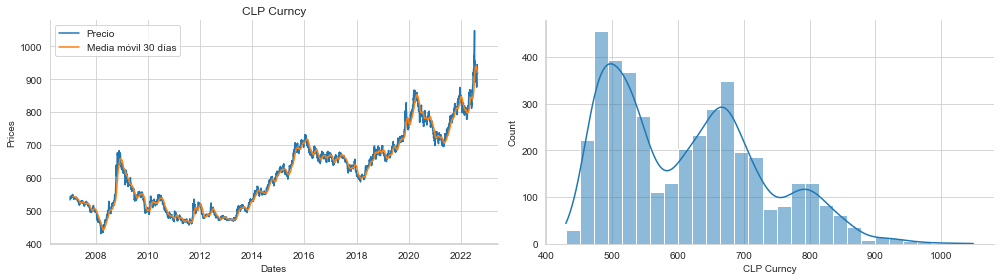

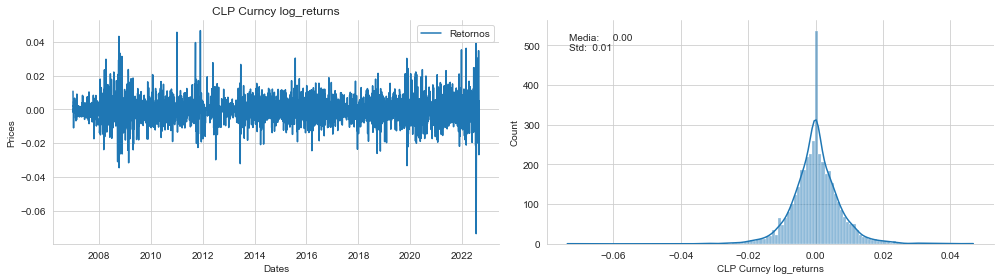

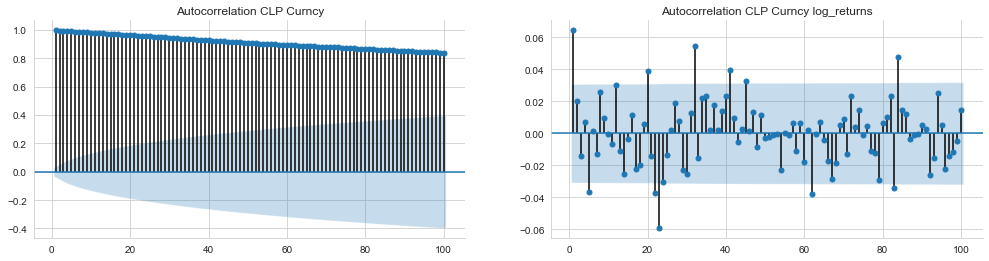

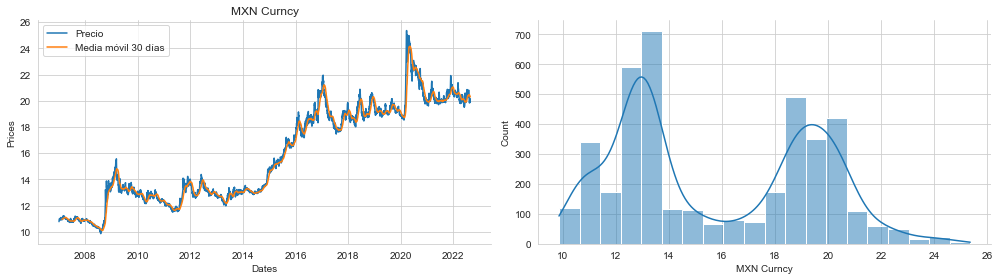

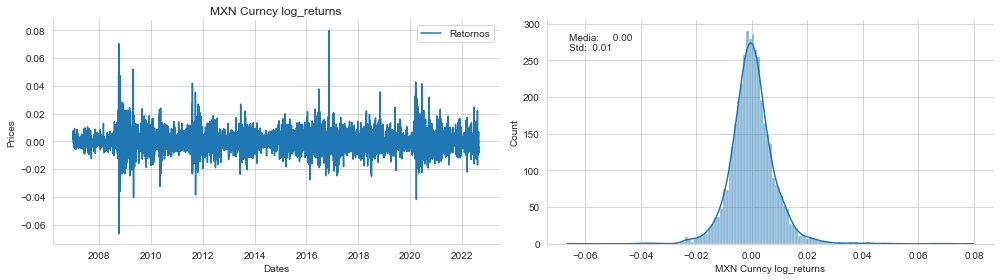

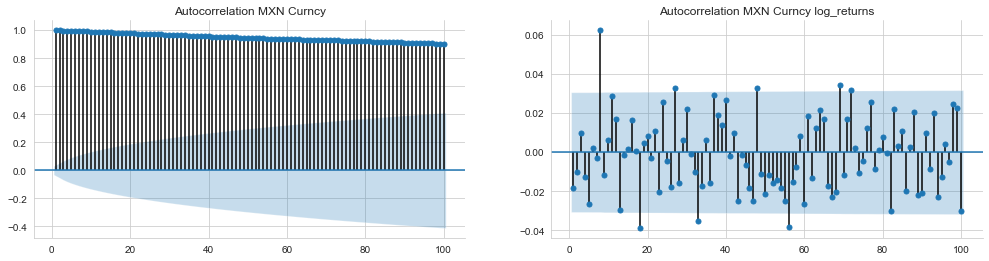

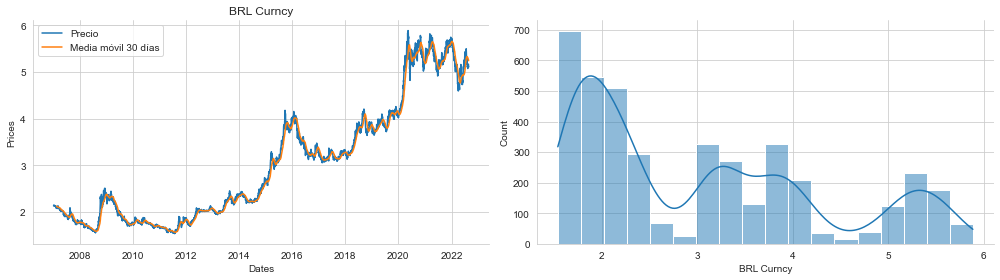

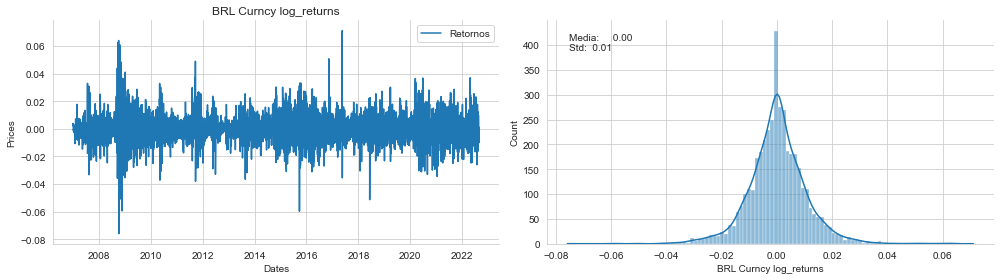

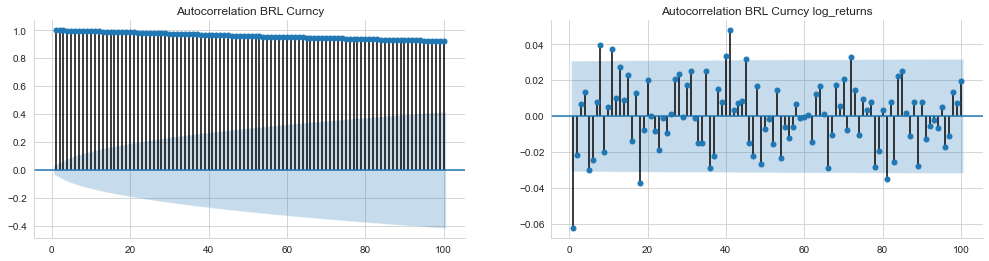

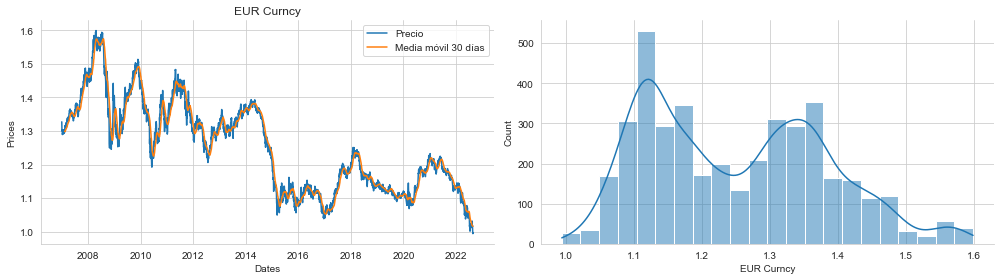

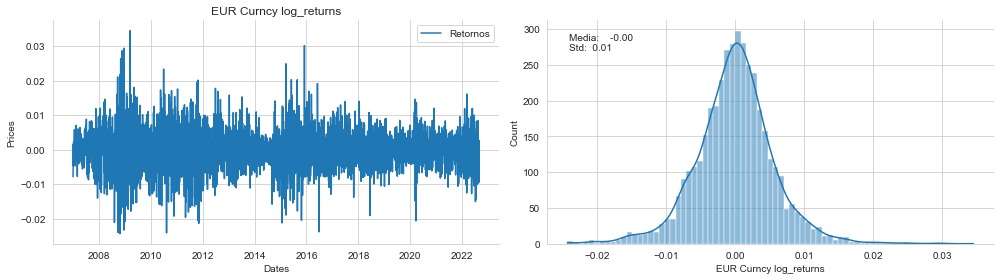

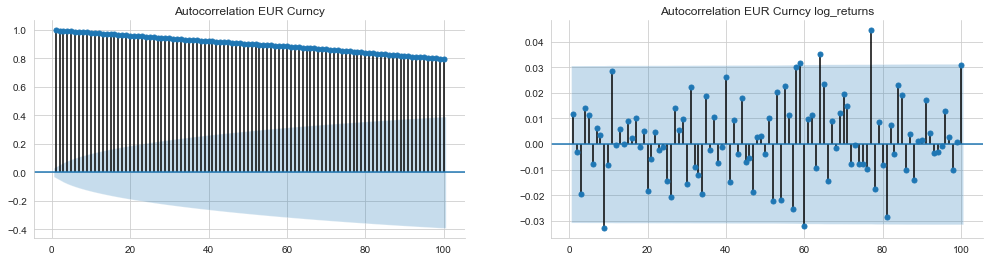

In [8]:
for i in range(df_an.shape[1]):
#         plt.xticks(rotation=90)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
        sns.histplot(df_an.iloc[:,i],ax=ax2,kde=True)
#          corregir dos cosas , que se giren los nombres del eje x 
        ax1.set_title(df_an.columns.values[i])
        ax1.plot(df_an.index, df_an.iloc[:,i],label="Precio")
        ax1.plot(dfma_an.index,dfma_an.iloc[:,i],label="Media móvil {} días".format(ventana_tiempo_media_movil))
        ax1.legend()
        ax1.set_xlabel('Dates')
        ax1.set_ylabel('Prices')
        sns.despine()
        fig.tight_layout();
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
        sns.histplot(dflog_an.iloc[:,i],ax=ax2,kde=True)
        
#         corregir dos cosas , que se giren los nombres del eje x y quizas estandarizar el plot
        ax1.set_title(dflog_an.columns.values[i])
        ax1.plot(dflog_an.index, dflog_an.iloc[:,i],label="Retornos")     #Agregar media quizas y desv estandar 
        ax1.legend()
        ax1.set_xlabel('Dates')
        ax1.set_ylabel('Prices')
        ax2.text(x=.05, y=.9,s=f'Media: {dflog_an.iloc[:,i].mean():8.2f}\nStd: {dflog_an.iloc[:,i].std():5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax2.transAxes)
        sns.despine()
        fig.tight_layout();
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17,4))
        plot_acf(df_an.iloc[:,i],ax=ax1, lags=100, zero=False, title='Autocorrelation {}'.format(df_an.columns.values[i]))
        plot_acf(dflog_an.iloc[:,i].dropna(),ax=ax2, lags=100, zero=False, title='Autocorrelation {}'.format(df_an.columns.values[i]+" log_returns"))
        sns.despine()

## Martiz de Correlaciones

In [10]:
ventana_de_tiempo_correlaciones=250

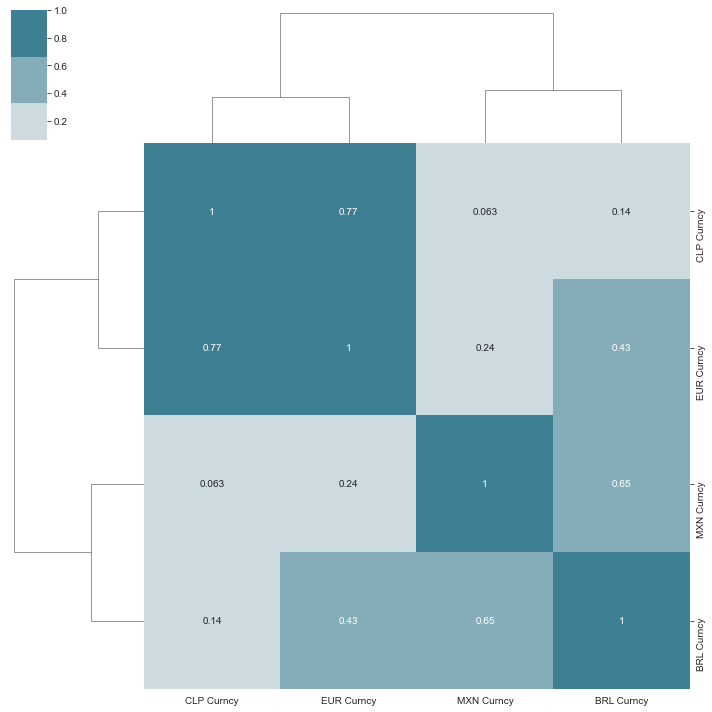

In [11]:
sns.clustermap(abs(df_an.iloc[-ventana_de_tiempo_correlaciones:,:].corr()), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True)#, fmt='.2%');#idea usar usar valor absoluto de la matriz de correlacion

## Matriz de correlaciones de log returns

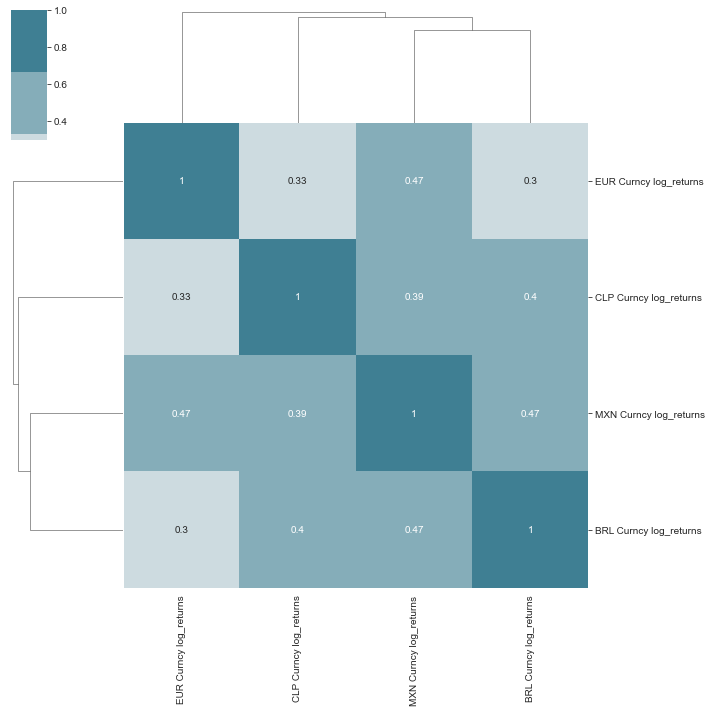

In [51]:
sns.clustermap(abs(dflog_an.iloc[-ventana_de_tiempo_correlaciones:,:].corr()), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True)#, fmt='.2%');#idea usar usar valor absoluto de la matriz de correlacion

In [52]:
list(df.columns.values)

['CLP Curncy',
 'HG1 Comdty',
 'SPX Index',
 'BBDXY Index',
 'LACI Index',
 'USOSFR1 Curncy',
 'USOSFR5 Curncy',
 'USOSFR10 Curncy',
 'MXN Curncy',
 'BRL Curncy',
 'EUR Curncy',
 'CL1 Comdty',
 'CHSWP1 Curncy',
 'CHSWP5 Curncy',
 'CHSWP10 Curncy',
 'IPSA Index']

## PCA Inverso

## Con que variables hacer pca inverso

In [11]:
variables_pca_inverso=variables_a_analizar
#variables_pca_inverso=['HG1 Comdty', 'BBDXY Index', 'LACI Index', 'USOSFR5 Curncy','MXN Curncy', 'BRL Curncy', 'EUR Curncy', 'CL1 Comdty','CHSWP5 Curncy',"CLP Curncy"]
dftest_pca=df.loc[:,variables_pca_inverso] 

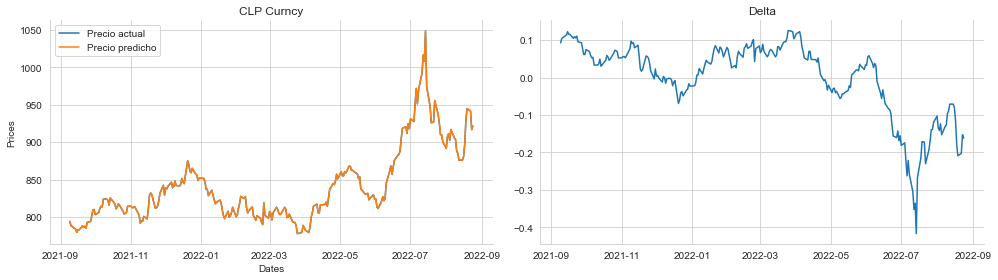

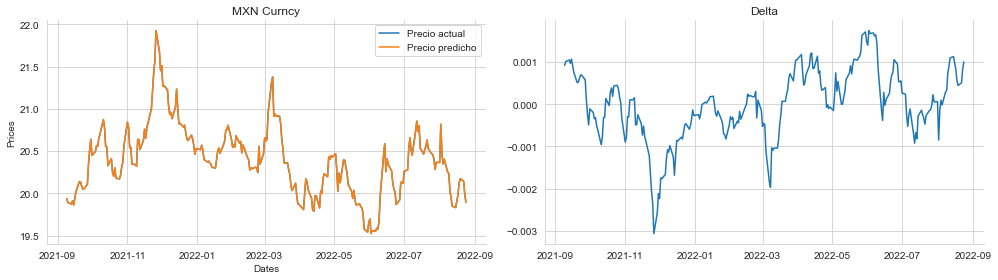

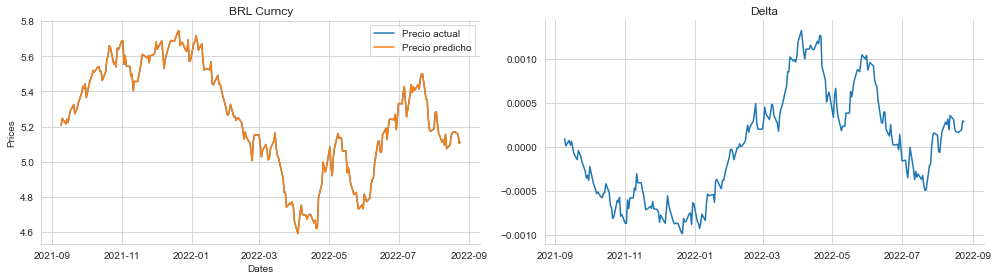

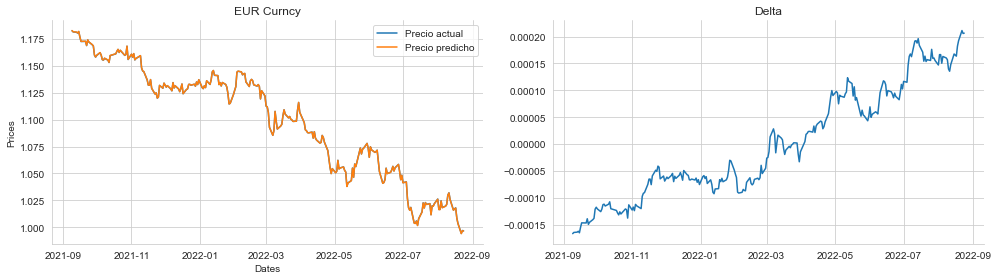

In [12]:
ventana_de_tiempo_pca_inverso=250
nc=len(variables_pca_inverso)     #componentes PCA
dftest_pca=dftest_pca.iloc[-ventana_de_tiempo_pca_inverso:]
std_scaler = StandardScaler()          
std_scaler.fit(dftest_pca)
dftest_media=dftest_pca.mean()    
dftest_std=dftest_pca.std()
dftest_scaled=std_scaler.transform(dftest_pca)
dftest_scaled=pd.DataFrame(dftest_scaled)
pca= decomposition.PCA(n_components=nc)
pca.fit((dftest_scaled))
valores=pca.transform((dftest_scaled))
valores_df=pd.DataFrame(valores)
valoresinv=pca.inverse_transform(valores)
valoresinv=(pd.DataFrame(valoresinv))
pca_componentes=pd.DataFrame(pca.components_)
pca_componentes.columns=variables_pca_inverso
pca_componentes.index=[" vector "+ str(i+1) for i in range(0,pca_componentes.shape[0])]

valoresinv.columns=list(dftest_pca.columns.values)
valoresinv=valoresinv*dftest_std+dftest_media
valoresinv.index=dftest_pca.index
valoresinv.add_suffix(" predict")
for i in range(dftest_pca.shape[1]):
#         plt.xticks(rotation=90)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
        #sns.histplot(dftest_pca.iloc[:,i],ax=ax2,kde=True)
#          corregir dos cosas , que se giren los nombres del eje x 
        ax1.set_title(dftest_pca.columns.values[i])
        ax1.plot(dftest_pca.index, dftest_pca.iloc[:,i],label="Precio actual")
        ax1.plot(valoresinv.index, valoresinv.iloc[:,i],label="Precio predicho")
        ax2.plot(valoresinv.index, dftest_pca.iloc[:,i]-valoresinv.iloc[:,i],label="Delta")
        ax1.legend()
        ax1.set_xlabel('Dates')
        ax1.set_ylabel('Prices')
        ax2.set_title("Delta")
        sns.despine()
        fig.tight_layout();
        plt.show()

Text(0.5, 1.0, 'Deltas')

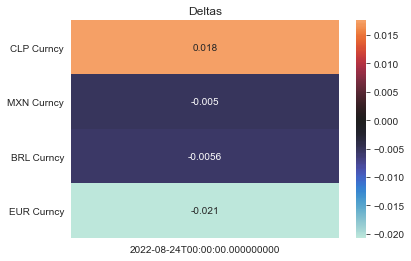

In [55]:
sns.heatmap((pd.DataFrame(((valoresinv.iloc[-1,:]-dftest_pca.iloc[-1,:])*100/dftest_pca.iloc[-1,:]).sort_values(ascending=False))),annot=True,center=0).set_title('Deltas')

In [13]:
dftest_pca.iloc[-1,:]

CLP Curncy    921.3800
MXN Curncy     19.8953
BRL Curncy      5.1107
EUR Curncy      0.9967
Name: 2022-08-24 00:00:00, dtype: float64

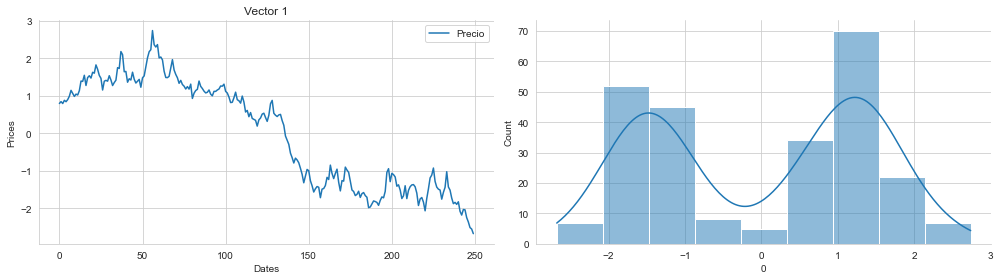

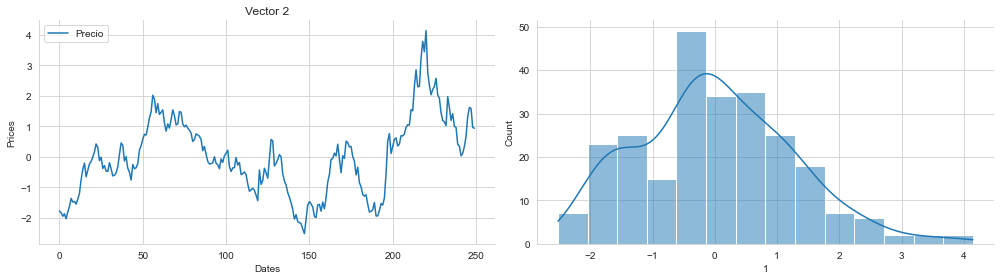

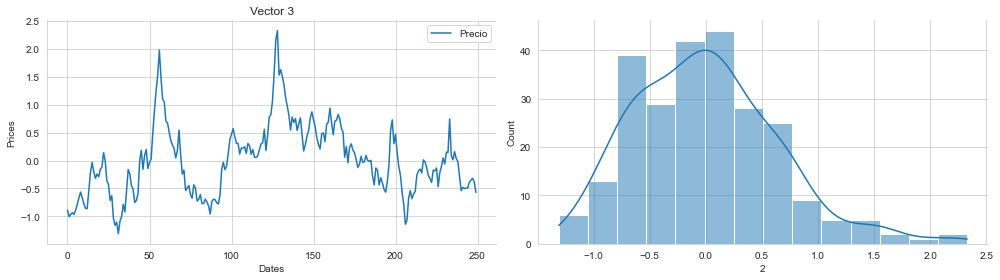

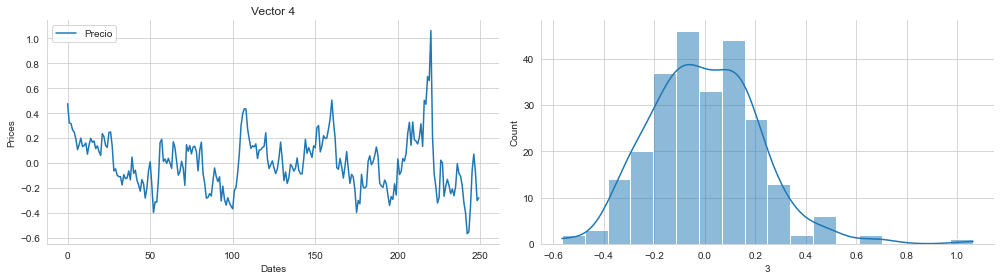

In [16]:
i=0
while i<(valores_df.shape[1]):
#         plt.xticks(rotation=90)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
        sns.histplot(valores_df.iloc[:,i],ax=ax2,kde=True)
#          corregir dos cosas , que se giren los nombres del eje x 
        ax1.set_title(f"Vector {valores_df.columns.values[i]+1}")
        ax1.plot(valores_df.index, valores_df.iloc[:,i],label="Precio")
        #ax1.plot(dfma.index,dfma.iloc[:,i],label="Media móvil {} días".format(ventana_tiempo_media_movil))
        ax1.legend()
        ax1.set_xlabel('Dates')
        ax1.set_ylabel('Prices')
        sns.despine()
        fig.tight_layout();
        i+=1

,Explained Variance,Cumulative Variance
vector 1,0.499709,0.500
vector 2,0.386688,0.887
vector 3,0.101803,0.989
vector 4,0.011800,1.001


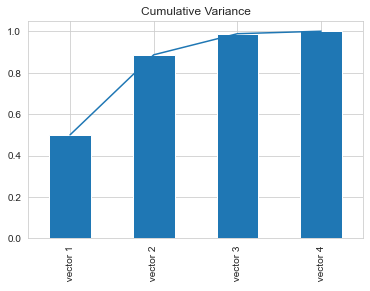

In [15]:
explained_variance=pca.explained_variance_ratio_
explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
df_explained_variance = pd.concat([ explained_variance_df, cumulative_variance_df], axis=1)
df_explained_variance.drop(0,axis=0,inplace=False)

df_explained_variance.index=[" vector "+ str(i) for i in range(0,df_explained_variance.shape[0])]
ax=df_explained_variance.iloc[1:,1].plot(title="Cumulative Variance")
ax=df_explained_variance.iloc[1:,1].plot.bar() 
df_explained_variance.iloc[1:,:]

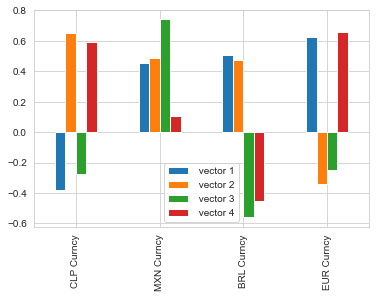

In [59]:
pca_componentes.transpose().plot(rot=90,kind="bar")

## RFE

In [60]:
def Rfe(modelo_a_usar,x_train,y_train,n_features):   
    features=x_train.columns.values
    std_scaler = StandardScaler()          
    std_scaler.fit(x_train)
    x_train=std_scaler.transform(x_train)
    selector = RFE(modelo_a_usar, n_features_to_select=n_features, step=1)
   # selector = RFECV(modelo_a_usar, min_features_to_select=n_features, step=1) 
    selector = selector.fit(x_train, y_train)
    return(features[selector.support_])

In [61]:
modelo_a_usar=LinearRegression()
n_features=2
x_train=df.iloc[:,:-1]         #hacer selector por fecha y por columna , para Y.
y_train=df.iloc[:,-1]
Rfe(modelo_a_usar,x_train,y_train,n_features)

array(['LACI Index', 'BRL Curncy'], dtype=object)

## LDA

In [24]:
def confusion_matrix_plot(Y,Y_pred):
    tn, fp, fn, tp = confusion_matrix(list(Y), list(Y_pred), labels=[0, 1]).ravel()
    print('True Positive:', tp)
    print('True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    ConfusionMatrixDisplay(confusion_matrix(Y, Y_pred,normalize="true")).plot(cmap='Greys')
    print("Precision score:",precision_score(Y, Y_pred))
    print(classification_report(Y, Y_pred))

True Positive: 1325
True Negative: 1265
False Positive: 780
False Negative: 711
Precision score: 0.6294536817102138
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      2045
           1       0.63      0.65      0.64      2036

    accuracy                           0.63      4081
   macro avg       0.63      0.63      0.63      4081
weighted avg       0.63      0.63      0.63      4081



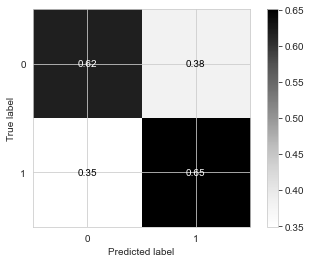

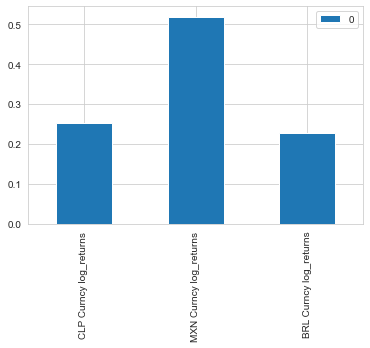

In [47]:
Y=dflog_an.iloc[:,-1].apply(lambda x: 1 if(x>0) else 0)
X=dflog_an.iloc[:,:-1]

std_scaler = StandardScaler()          
std_scaler.fit(X)
X_scaled=std_scaler.transform(X)
X_scaled=pd.DataFrame(X_scaled)
lda = LDA(n_components=1)
lda_x = lda.fit(X_scaled, Y).transform(X_scaled)

lda_df=pd.DataFrame(abs(lda.coef_)/abs(lda_df.sum(axis=1)).iloc[0])
lda_df.columns=list(X.columns)
lda_x_pred=lda.predict(X_scaled)
confusion_matrix_plot(Y,lda_x_pred)
lda_df.transpose().plot(rot=90,kind="bar")



C:\Users\augus\anaconda3\lib\site-packages\pandas\core\internals\construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
C:\Users\augus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\augus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with 

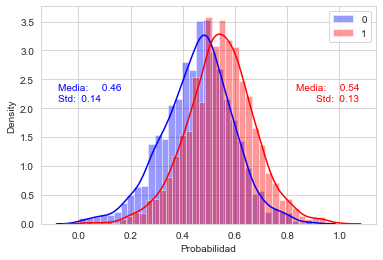

In [48]:
y0_preds = (lda.predict_proba(X_scaled))[np.where(Y == 0), 1]
y1_preds = (lda.predict_proba(X_scaled))[np.where(Y == 1), 1]
pd.DataFrame([y0_preds,y1_preds])
ax=sns.distplot(y0_preds, color='blue',label="0")
ax=sns.distplot(y1_preds, color='red',label="1")
ax.legend()
ax.set_xlabel('Probabilidad')
ax.text(x=.05, y=.6,s=f'Media: {y0_preds.mean():8.2f}\nStd: {y0_preds.std():5.2f}',horizontalalignment='left',verticalalignment='center',c="blue",transform=ax.transAxes)
ax.text(x=.95, y=.6,s=f'Media: {y1_preds.mean():8.2f}\nStd: {y1_preds.std():5.2f}',horizontalalignment='right',verticalalignment='center',c="red",transform=ax.transAxes)
plt.show()